### SP025 Integration analysis Ovarian TME 

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import loompy as lp
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.4.1 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.2


In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.4.1 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.2


In [4]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths("/home/spuccio/miniconda3/envs/scrnseq/lib/R/library")

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
library(clustree)
library(SingleCellExperiment)
library(CHETAH)
library(SingleR)
library(cowplot)
library(Matrix)

### Load Dataset CRC 

In [5]:
path_oc="/home/spuccio/isilon/spuccio/SP025_NaClTcell/PangenomeBlueprint/OvC_counts/"
adata_oc = sc.read("".join([path_oc,"matrix.mtx"]), cache=True)
adata_oc = adata_oc.transpose()
adata_oc.X = adata_oc.X.toarray()
barcodes = pd.read_csv("".join([path_oc,"barcodes.tsv"]), header=None, sep='\t')
genes = pd.read_csv("".join([path_oc,"genes.tsv"]), header=None, sep='\t')
#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata_oc.obs = barcodes
genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata_oc.var = genes
Metadata_oc = pd.read_csv("/home/spuccio/isilon/spuccio/SP025_NaClTcell/PangenomeBlueprint/OvC_metadata.csv",header=0,low_memory=False)
adata_oc.obs['CellId'] = Metadata_oc["Cell"].to_list()
adata_oc.obs['CellFromTumor'] = Metadata_oc["CellFromTumor"].to_list()
adata_oc.obs['PatientNumber'] = Metadata_oc["PatientNumber"].to_list()
adata_oc.obs['TumorType'] = Metadata_oc["TumorType"].to_list()
adata_oc.obs['TumorSite'] = Metadata_oc["TumorSite"].to_list()
adata_oc.obs['CellType'] = Metadata_oc["CellType"].to_list()

... reading from cache file cache/home-spuccio-isilon-spuccio-SP025_NaClTcell-PangenomeBlueprint-OvC_counts-matrix.h5ad


In [6]:
adata_oc_Tcell = adata_oc[adata_oc.obs['CellType']  == "T_cell",:]
adata_oc_Cancer = adata_oc[adata_oc.obs['CellType']  == "Cancer",:]

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


### Filter low expressed genes

In [7]:
sc.pp.filter_genes(adata_oc_Tcell, min_cells=10)
sc.pp.filter_cells(adata_oc_Tcell, min_genes=200)

filtered out 19797 genes that are detected in less than 10 cells


Trying to set attribute `.var` of view, copying.


In [8]:
adata_oc_Tcell.raw = adata_oc_Tcell

### QC metrics

In [9]:
sc.pp.calculate_qc_metrics(adata_oc_Tcell, inplace=True)

In [10]:
adata_oc_Tcell.var['mt'] = adata_oc_Tcell.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_oc_Tcell, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [11]:
adata_oc_Tcell.var['rb'] = adata_oc_Tcell.var_names.str.startswith('RP')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_oc_Tcell, qc_vars=['rb'], percent_top=None, log1p=False, inplace=True)

In [12]:
#sc.pl.violin(adata_oc_Tcell, ['pct_counts_mt'],
#             jitter=0.4, multi_panel=False)

normalizing counts per cell
    finished (0:00:00)


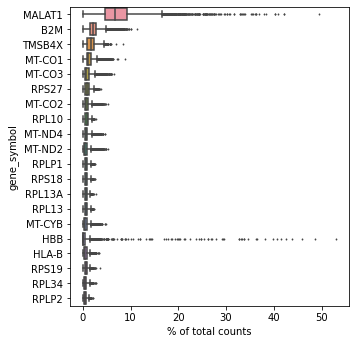

In [13]:
sc.pl.highest_expr_genes(adata_oc_Tcell, n_top=20)

In [14]:
print("Cell x Genes before filtering")
print(adata_oc_Tcell.n_obs, adata_oc_Tcell.n_vars)

Cell x Genes before filtering
6105 13897


In [15]:
#sc.pl.violin(adata_oc_Tcell, ['pct_counts_rb'],jitter=0.4)

In [16]:
adata_oc_Tcell = adata_oc_Tcell[adata_oc_Tcell.obs.pct_counts_rb < 45, :]
print("Cell x Genes after filtering cell with high ribosomial")
print(adata_oc_Tcell.n_obs, adata_oc_Tcell.n_vars)

Cell x Genes after filtering cell with high ribosomial
5926 13897


/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [17]:
#sc.pl.violin(adata_oc_Tcell, ['pct_counts_mt'],jitter=0.4)

In [18]:
adata_oc_Tcell = adata_oc_Tcell[adata_oc_Tcell.obs.pct_counts_mt < 10, :]
print("Cell x Genes after filtering cell with high mithocondrial")
print(adata_oc_Tcell.n_obs, adata_oc_Tcell.n_vars)

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Cell x Genes after filtering cell with high mithocondrial
4684 13897


In [19]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["external_gene_name", "start_position", "end_position", "chromosome_name","gene_biotype"],).set_index("external_gene_name")

In [20]:
annot['gene_biotype'].unique()

array(['Mt_tRNA', 'Mt_rRNA', 'protein_coding', 'processed_pseudogene',
       'lncRNA', 'snRNA', 'unprocessed_pseudogene', 'misc_RNA',
       'transcribed_unprocessed_pseudogene',
       'transcribed_processed_pseudogene', 'TEC', 'rRNA',
       'IG_V_pseudogene', 'rRNA_pseudogene', 'miRNA',
       'transcribed_unitary_pseudogene', 'unitary_pseudogene', 'snoRNA',
       'scaRNA', 'polymorphic_pseudogene', 'pseudogene', 'ribozyme',
       'sRNA', 'TR_V_gene', 'TR_V_pseudogene', 'TR_D_gene', 'TR_J_gene',
       'TR_C_gene', 'TR_J_pseudogene', 'IG_C_gene', 'IG_C_pseudogene',
       'IG_J_gene', 'IG_J_pseudogene', 'IG_D_gene', 'IG_V_gene',
       'IG_pseudogene', 'translated_processed_pseudogene', 'scRNA',
       'vault_RNA', 'translated_unprocessed_pseudogene'], dtype=object)

In [21]:
#len(pd.merge(pd.DataFrame(adata_oc_Tcell.var_names),annot,left_on="gene_symbol",right_on="external_gene_name",how="left"))

In [22]:
annot = pd.merge(pd.DataFrame(adata_oc_Tcell.var_names),annot,left_on="gene_symbol",right_on="external_gene_name",how="left")

In [23]:
annot= annot.drop_duplicates(['gene_symbol'])

In [24]:
annot = annot.fillna("Not_available")

In [25]:
adata_oc_Tcell.var['gene_biotype'] = annot.set_index("gene_symbol")['gene_biotype']
protein_coding = annot['gene_symbol'].loc[annot['gene_biotype']=="protein_coding"].reset_index()
del protein_coding['index']
protein_gene_indicator = np.in1d(adata_oc_Tcell.var_names, protein_coding)
adata_oc_Tcell = adata_oc_Tcell[:, protein_gene_indicator]

Trying to set attribute `.var` of view, copying.


In [26]:
mito_gene_names = sc.queries.mitochondrial_genes("hsapiens")

In [27]:
mito_gene_indicator = np.in1d(adata_oc_Tcell.var_names, mito_gene_names)

In [28]:
adata_oc_Tcell = adata_oc_Tcell[:, ~mito_gene_indicator]

In [29]:
adata_oc_Tcell

View of AnnData object with n_obs × n_vars = 4684 × 12026
    obs: 'CellId', 'CellFromTumor', 'PatientNumber', 'TumorType', 'TumorSite', 'CellType', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb'
    var: 'gene_id', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'rb', 'gene_biotype'

In [30]:
print(adata_oc_Tcell.n_obs, adata_oc_Tcell.n_vars)
malat1 = adata_oc_Tcell.var_names.str.startswith('MALAT1')
#protein_genes= adata_oc_Tcell.var.gene_biotype.str.startswith('protein_coding')
ribo_genes = adata_oc_Tcell.var_names.str.startswith(("RPS","RPL"))
remove = np.add(ribo_genes, malat1)
keep = np.invert(remove)

adata_oc_Tcell = adata_oc_Tcell[:,keep]

print(adata_oc_Tcell.n_obs, adata_oc_Tcell.n_vars)

4684 12026
4684 11934


In [31]:
print(adata_oc_Tcell.n_obs, adata_oc_Tcell.n_vars)

4684 11934


In [32]:
adata_oc_Tcell.raw = adata_oc_Tcell

In [33]:
sc.pp.normalize_total(adata_oc_Tcell, target_sum=1e4,exclude_highly_expressed=True)
sc.pp.log1p(adata_oc_Tcell)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['GNLY', 'EEF1A1', 'ACTB', 'TMSB4X', 'HBB', 'GZMB', 'B2M', 'HBA2', 'HBA1', 'MT2A', 'MT1X', 'CCL4', 'FTL']
    finished (0:00:00)


In [34]:
sc.pp.highly_variable_genes(adata_oc_Tcell, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [35]:
adata_oc_Tcell.raw = adata_oc_Tcell

In [36]:
#pd.DataFrame(adata_oc_Tcell.var.highly_variable).loc[pd.DataFrame(adata_oc_Tcell.var.highly_variable)['highly_variable'] == True].head(50)

normalizing counts per cell
    finished (0:00:00)


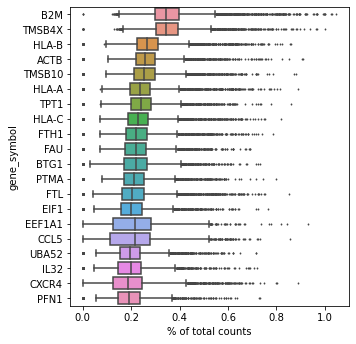

In [37]:
sc.pl.highest_expr_genes(adata_oc_Tcell, n_top=20)

### Principal component analysis

In [38]:
#adata_oc_Tcell = adata_oc_Tcell[:, adata_oc_Tcell.var.highly_variable]

In [39]:
#sc.pp.scale(adata_oc_Tcell, max_value=10)

In [40]:
sc.tl.pca(adata_oc_Tcell, svd_solver='arpack',use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50


/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:00)


/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'TumorType' as categorical
... storing 'TumorSite' as categorical
... storing 'CellType' as categorical
... storing 'gene_biotype' as categorical


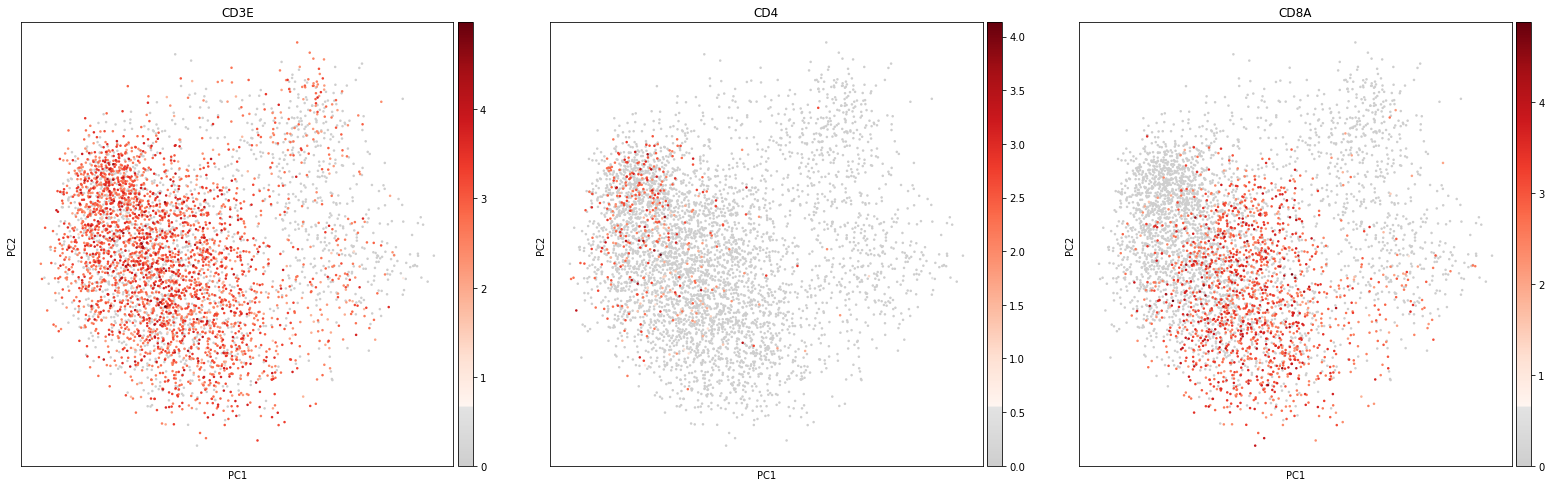

In [41]:

colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
sc.pl.pca(adata_oc_Tcell, color=['CD3E','CD4','CD8A'],color_map=mymap)

### Computing the neighborhood graph

In [42]:
sc.pp.neighbors(adata_oc_Tcell, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


### Embedding the neighborhood graph

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


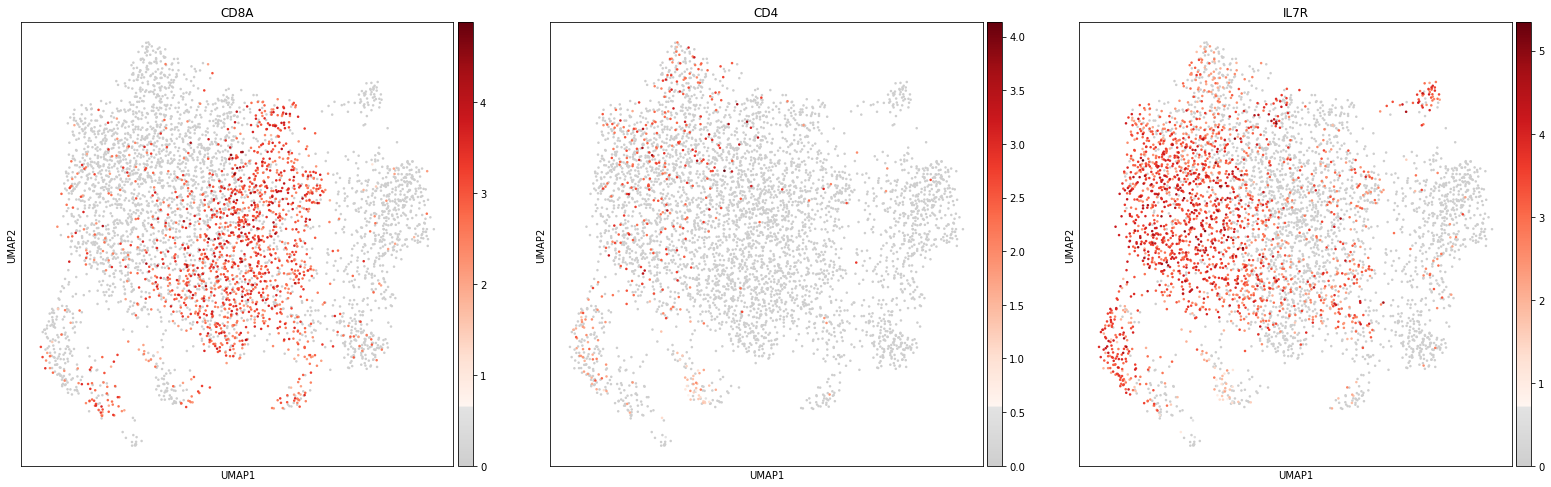

In [43]:
sc.tl.umap(adata_oc_Tcell)
sc.pl.umap(adata_oc_Tcell, color=['CD8A', 'CD4', 'IL7R'],color_map=mymap,use_raw=True); plt.show()

### Clustering the neighborhood graph

In [44]:
sc.tl.leiden(adata_oc_Tcell, resolution=0.7, key_added='leiden_r7_clusters')
sc.tl.leiden(adata_oc_Tcell, resolution=0.5, key_added='leiden_r5_clusters')
sc.tl.leiden(adata_oc_Tcell, resolution=0.4, key_added='leiden_r4_clusters')
sc.tl.leiden(adata_oc_Tcell, resolution=0.6, key_added='leiden_r6_clusters')
sc.tl.leiden(adata_oc_Tcell, resolution=0.8, key_added='leiden_r8_clusters')

running Leiden clustering
    finished: found 11 clusters and added
    'leiden_r7_clusters', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_r5_clusters', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_r4_clusters', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_r6_clusters', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_r8_clusters', the cluster labels (adata.obs, categorical) (0:00:00)


In [45]:
data_clus = adata_oc_Tcell.obs[['leiden_r7_clusters','leiden_r6_clusters','leiden_r5_clusters','leiden_r4_clusters','leiden_r8_clusters']]

In [46]:
data_clus.to_csv("/mnt/lugli/spuccio/SP028_Autoimmunity/h5_files/temp.csv",index=True,header=True)
data_clus2 = pd.read_csv("/mnt/lugli/spuccio/SP028_Autoimmunity/h5_files/temp.csv",index_col=0,header=0)

In [47]:
# these are the defaults we want to set:
default_units = 'in' # inch, to make it more easily comparable to matpplotlib
default_res = 100 # dpi, same as default in matplotlib
default_width = 10
default_height = 9
# try monkey-patching a function in rpy2, so we effectively get these
# default settings for the width, height, and units arguments of the %R magic command
import rpy2
old_setup_graphics = rpy2.ipython.rmagic.RMagics.setup_graphics

def new_setup_graphics(self, args):
    if getattr(args, 'units') is not None:
        if args.units != default_units: # a different units argument was passed, do not apply defaults
            return old_setup_graphics(self, args)
    args.units = default_units
    if getattr(args, 'res') is None:
        args.res = default_res
    if getattr(args, 'width') is None:
        args.width = default_width
    if getattr(args, 'height') is None:
        args.height = default_height        
    return old_setup_graphics(self, args)

rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

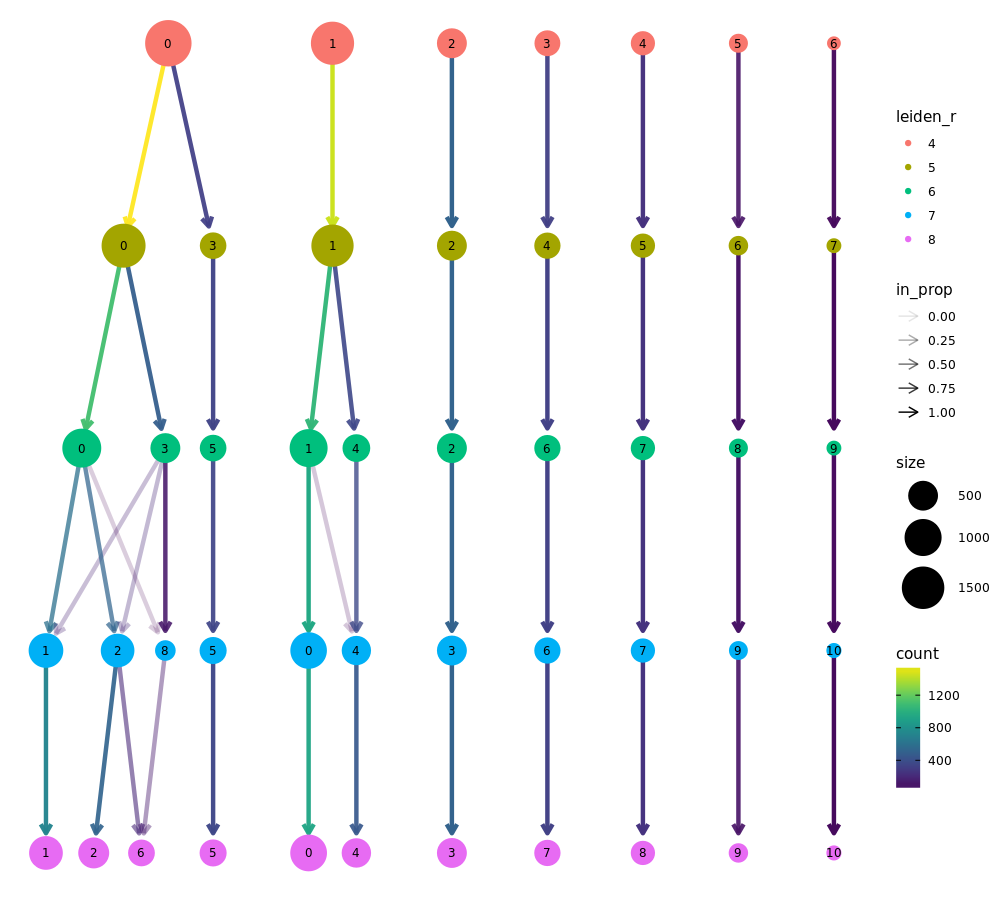

In [48]:
%%R -i data_clus2
library(clustree)

clustree(data_clus2,prefix="leiden_r",suffix = "_clusters")

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


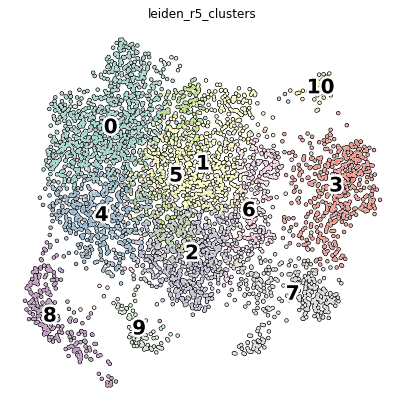

In [49]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata_oc_Tcell, color='leiden_r8_clusters', add_outline=True,legend_loc='on data', 
           legend_fontsize=20, legend_fontoutline=5,frameon=False,
           title='leiden_r5_clusters', palette='Set3')

In [50]:
sc.tl.paga(adata_oc_Tcell,groups='leiden_r8_clusters')
sc.pl.paga(adata_oc_Tcell, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_oc_Tcell, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


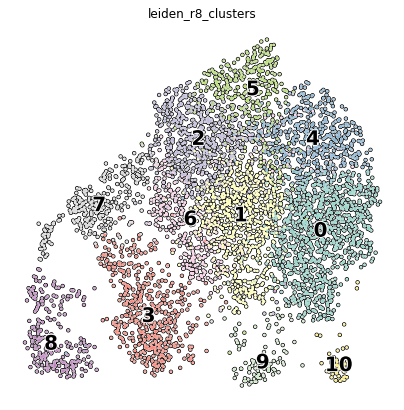

In [51]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata_oc_Tcell, color='leiden_r8_clusters', add_outline=True,legend_loc='on data', 
           legend_fontsize=20, legend_fontoutline=2,frameon=False,
           title='leiden_r8_clusters', palette='Set3')

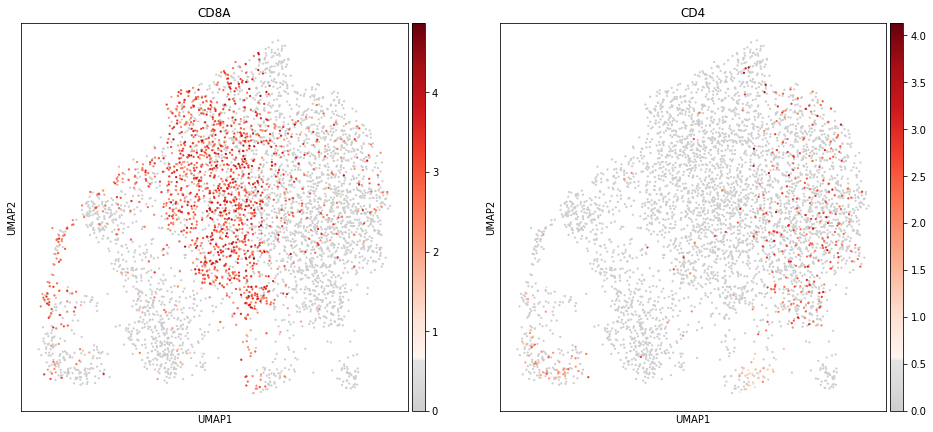

In [52]:
sc.pl.umap(adata_oc_Tcell, color=['CD8A','CD4'],color_map=mymap,legend_loc='on data',s=20 )

### Finding marker genes

In [53]:
sc.tl.rank_genes_groups(adata_oc_Tcell, 'leiden_r8_clusters', method='wilcoxon')
pd.DataFrame(adata_oc_Tcell.uns['rank_genes_groups']['names']).head(50)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


,0,1,2,3,4,5,6,7,8,9,10
0,LTB,CD8A,GZMK,TYROBP,IL7R,HBB,CD8A,NKG7,SPP1,TUBA1B,LST1
1,EEF1A1,CCL5,CCL4,FCER1G,JUNB,HBA2,GZMB,GZMB,S100A9,STMN1,AREG
2,TPT1,CD8B,CCL5,CD7,TSC22D3,HBA1,CD8B,PRF1,SLPI,TUBB,LTB
3,S100A4,EEF1A1,CXCR4,XCL2,FOS,COL1A2,CD7,GNLY,FTL,HMGB2,TNFSF13B
4,IL7R,GZMK,CST7,GNLY,ANXA1,COL1A1,CD3D,KLRD1,S100A8,GAPDH,EEF1A1
5,CD52,CD3D,CD8A,KLRC1,SARAF,COL3A1,TMSB4X,FGFBP2,NBEAL1,TYMS,TPT1
6,TMSB10,CD74,CD74,XCL1,SRGN,FTL,HOPX,FCGR3A,IFITM1,ACTG1,KRT86
7,EEF1B2,CD27,SRGN,CTSW,ZFP36,CXCR4,KLRC1,KLRF1,TIMP1,MKI67,KLRB1
8,BIRC3,HLA-DPB1,GZMH,KLRD1,CXCR4,MT2A,S100A6,CST7,IL32,SMC2,TNFRSF18
9,CORO1B,NKG7,ZFP36,KRT86,LEPROTL1,SPARC,CCL4,GZMH,C1QB,CKS1B,KRT81


/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/spu

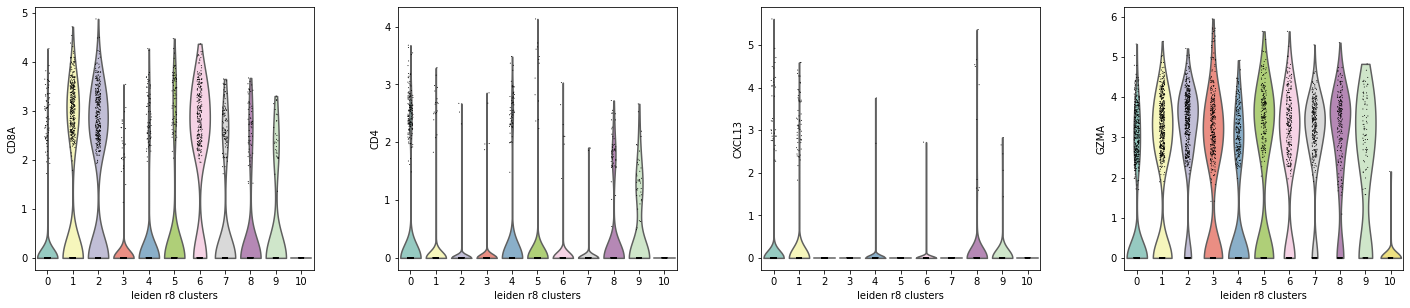

In [54]:
rcParams['figure.figsize'] = 5,5
sc.pl.violin(adata_oc_Tcell, ['CD8A', 'CD4','CXCL13','GZMA'], groupby='leiden_r8_clusters')

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/spu

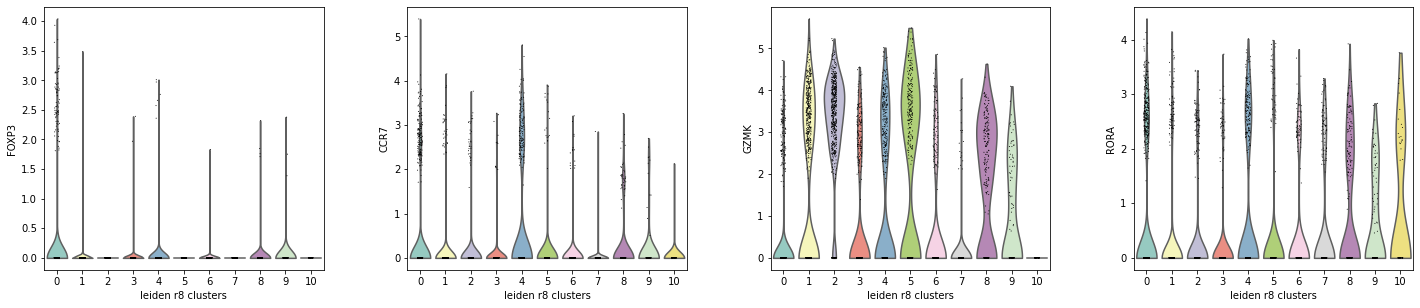

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/spu

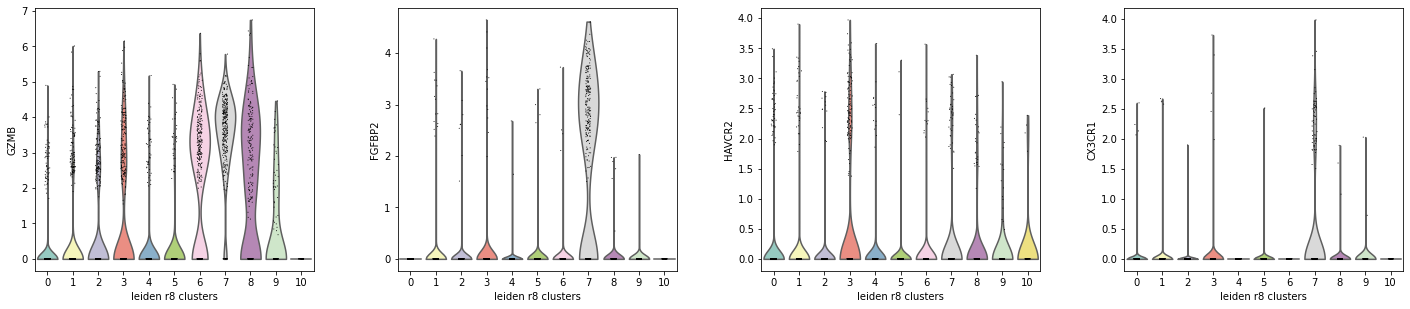

In [55]:
rcParams['figure.figsize'] = 5,5
sc.pl.violin(adata_oc_Tcell, ['FOXP3','CCR7','GZMK','RORA'], groupby='leiden_r8_clusters' )
sc.pl.violin(adata_oc_Tcell, ['GZMB','FGFBP2','HAVCR2','CX3CR1'], groupby='leiden_r8_clusters' )

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/spu

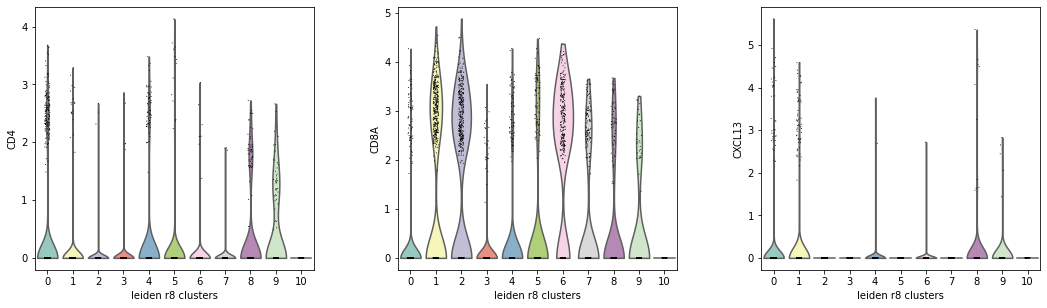

In [56]:
rcParams['figure.figsize'] = 5,5
sc.pl.violin(adata_oc_Tcell, ['CD4','CD8A','CXCL13'], groupby='leiden_r8_clusters' )

In [57]:
new_cluster_names = [
        'C0_CD4_FOXP3', 'C1_CD8_HAVCR2','C2_CD8_GZMK','C3_NK_XCL1','C4_CD4_CCR7','C5_CD8_GZMK','C6_CD8_ZNF683','C7_CD8_ZNF683','C8_CD4_CXCL13','C9_CD4_EZH2','C10_NK_FGFBP2']
adata_oc_Tcell.rename_categories('leiden_r8_clusters', new_cluster_names)

In [58]:
adata_oc_Tcell.obs['leiden_r8_clusters']

barcode
BT1303_AAACCTGTCAGGCCCA         C5_CD8_GZMK
BT1303_AAAGATGAGAGGGCTT         C5_CD8_GZMK
BT1303_AAAGATGAGCAATATG         C5_CD8_GZMK
BT1303_AAATGCCAGAAGGCCT         C5_CD8_GZMK
BT1303_AAATGCCTCCGGCACA         C5_CD8_GZMK
                                  ...      
scrSOL007_TGTTCCGCATTACCTT    C7_CD8_ZNF683
scrSOL007_TTAGGACGTAAACACA    C1_CD8_HAVCR2
scrSOL007_TTCCCAGTCCGCATCT      C9_CD4_EZH2
scrSOL007_TTCCCAGTCTATCGCC      C2_CD8_GZMK
scrSOL007_TTCTCAACATCCCACT      C2_CD8_GZMK
Name: leiden_r8_clusters, Length: 4684, dtype: category
Categories (11, object): ['C0_CD4_FOXP3', 'C1_CD8_HAVCR2', 'C2_CD8_GZMK', 'C3_NK_XCL1', ..., 'C7_CD8_ZNF683', 'C8_CD4_CXCL13', 'C9_CD4_EZH2', 'C10_NK_FGFBP2']

In [59]:
marker_genes_dict = {'T-cell': ['CD8A','CD4'],
                     'C0_CD4_FOXP3': ['FOXP3'],
                     'C1_CD8_HAVCR2': ['HAVCR2'],
                     'C2_CD8_GZMK': ['GZMK'],
                     'C3_NK_XCL1': ['XCL1'],
                     'C4_CD4_CCR7': ['CCR7'],
                     'C5_CD8_GZMK': ['GZMK'],
                     'C6_CD8_CX3CR1' : ['FGFBP2','NKG7'],
                     'C7_CD8_ZNF683' : ['ZNF683'],
                     'C8_CD4_CXCL13' : ['CXCL13'],
                     'C9_CD4_EZH2' : ['EZH2'],
                     'C10_NK_FGFBP2' : ['FGFBP2','NKG7']}

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['leiden_r8_clusters']"]`
categories: C0_CD4_FOXP3, C1_CD8_HAVCR2, C2_CD8_GZMK, etc.
var_group_labels: T-cell, C0_CD4_FOXP3, C1_CD8_HAVCR2, etc.


/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


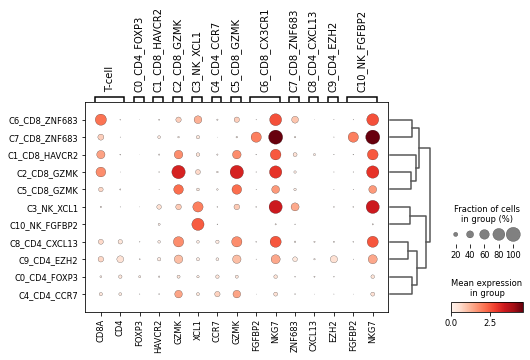

In [60]:
rcParams['figure.figsize'] = 10,10
sc.pl.dotplot(adata_oc_Tcell, marker_genes_dict, 'leiden_r8_clusters', dendrogram=True)

In [61]:
sc.tl.dendrogram(adata_oc_Tcell, 'leiden_r8_clusters')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['leiden_r8_clusters']"]`


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_r8_clusters']`


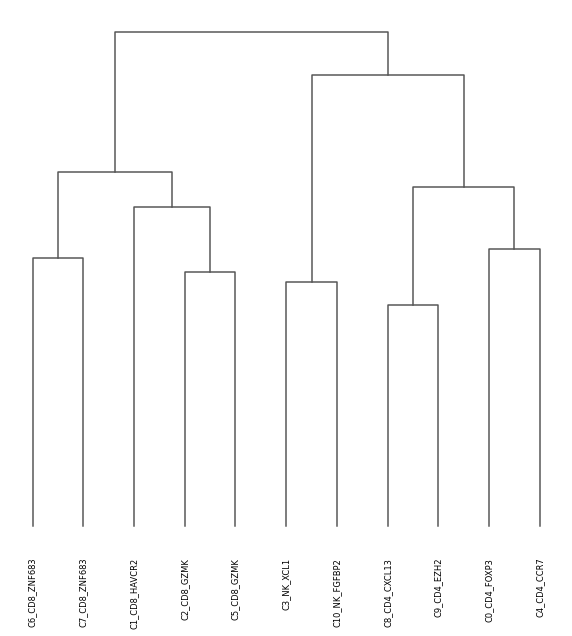

In [62]:
ax = sc.pl.dendrogram(adata_oc_Tcell, 'leiden_r8_clusters')

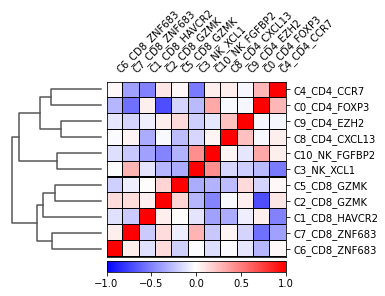

In [63]:
ax = sc.pl.correlation_matrix(adata_oc_Tcell, 'leiden_r8_clusters', figsize=(5,3.5))

In [64]:
adata_oc_Tcell.obs['leiden_r8_clusters'].value_counts()

C0_CD4_FOXP3     975
C1_CD8_HAVCR2    746
C2_CD8_GZMK      565
C3_NK_XCL1       505
C4_CD4_CCR7      478
C5_CD8_GZMK      357
C6_CD8_ZNF683    343
C7_CD8_ZNF683    322
C8_CD4_CXCL13    240
C9_CD4_EZH2      103
C10_NK_FGFBP2     50
Name: leiden_r8_clusters, dtype: int64

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


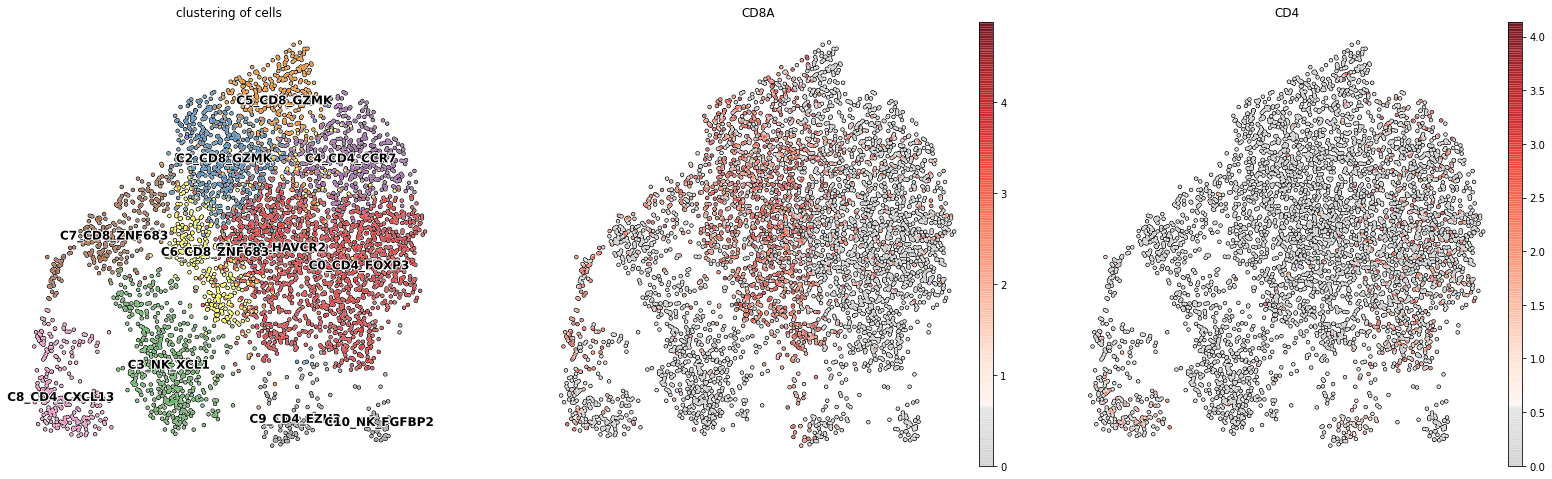

In [65]:
rcParams['figure.figsize'] = 8, 8
sc.pl.umap(adata_oc_Tcell, color=['leiden_r8_clusters','CD8A','CD4'],color_map=mymap, add_outline=True,legend_loc='on data', 
           legend_fontsize=12, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette='Set1')

### Filter NK cluster and compute again DEGS

In [66]:
adata_oc_Tcell_sub = adata_oc_Tcell[adata_oc_Tcell.obs['leiden_r8_clusters'].isin(['C0_CD4_FOXP3', 'C1_CD8_HAVCR2','C2_CD8_GZMK','C4_CD4_CCR7','C5_CD8_GZMK','C6_CD8_ZNF683','C7_CD8_ZNF683','C8_CD4_CXCL13','C9_CD4_EZH2']),:]

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [67]:
adata_oc_Tcell_sub

View of AnnData object with n_obs × n_vars = 4129 × 11934
    obs: 'CellId', 'CellFromTumor', 'PatientNumber', 'TumorType', 'TumorSite', 'CellType', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'leiden_r7_clusters', 'leiden_r5_clusters', 'leiden_r4_clusters', 'leiden_r6_clusters', 'leiden_r8_clusters'
    var: 'gene_id', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'rb', 'gene_biotype', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_r8_clusters_colors', 'paga', 'leiden_r8_clusters_sizes', 'rank_genes_groups', "dendrogram_['leiden_r8_clusters']", 'dendrogram_leiden_r8_c

Trying to set attribute `.uns` of view, copying.


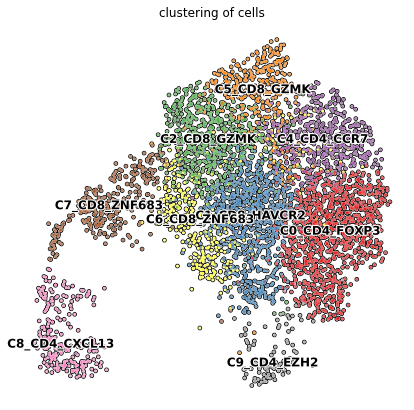

In [68]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata_oc_Tcell_sub, color=['leiden_r8_clusters'], add_outline=True,legend_loc='on data', 
           legend_fontsize=12, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette='Set1',color_map=mymap)

In [69]:
sc.tl.rank_genes_groups(adata_oc_Tcell_sub, 'leiden_r8_clusters', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


In [70]:
pd.DataFrame(adata_oc_Tcell_sub.uns['rank_genes_groups']['names']).head(50)

,C0_CD4_FOXP3,C1_CD8_HAVCR2,C2_CD8_GZMK,C4_CD4_CCR7,C5_CD8_GZMK,C6_CD8_ZNF683,C7_CD8_ZNF683,C8_CD4_CXCL13,C9_CD4_EZH2
0,LTB,CCL5,GZMK,IL7R,HBB,CD7,NKG7,SPP1,TUBA1B
1,EEF1A1,EEF1A1,CCL5,JUNB,HBA2,GZMB,GZMB,S100A9,STMN1
2,TPT1,CD8A,CCL4,FOS,HBA1,CD8A,GNLY,SLPI,TUBB
3,S100A4,NKG7,CST7,TSC22D3,COL1A2,CD8B,PRF1,FTL,HMGB2
4,CD52,CD8B,CXCR4,SRGN,COL1A1,KLRC1,KLRD1,S100A8,GAPDH
5,IL7R,CCL4,KLRD1,SARAF,COL3A1,HOPX,FGFBP2,NBEAL1,TYMS
6,EEF1B2,GZMK,SRGN,ANXA1,FTL,TMSB4X,FCGR3A,IFITM1,MKI67
7,KLRB1,HMGN2,NKG7,ZFP36,CXCR4,CCL5,TYROBP,IL32,ACTG1
8,BIRC3,ITM2C,CTSW,CXCR4,SPARC,XCL1,KLRF1,TIMP1,CKS1B
9,SH3BGRL3,APOBEC3G,ZFP36,LEPROTL1,MT2A,ZNF683,CST7,C1QB,SMC2


### Cluster information

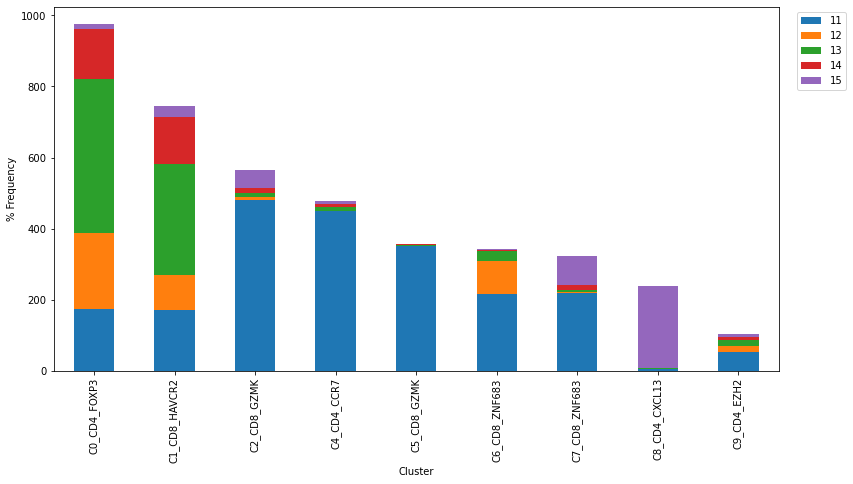

In [71]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata_oc_Tcell_sub.obs.groupby("leiden_r8_clusters")["PatientNumber"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

### Export list and object

In [72]:
result = adata_oc_Tcell_sub.uns['rank_genes_groups']

In [73]:
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:3]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).to_csv("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/Ovarian_output/Ovarian_DEGS.csv",header=True,index=False)

In [74]:
adata_oc_Tcell_sub.write("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/Ovarian_output/adata_oc_Tcell_sub.h5ad")
adata_oc_Tcell.write("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/Ovarian_output/adata_oc_Tcell.h5ad")

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'gene_biotype' as categorical
... storing 'gene_biotype' as categorical
